In [1]:
from src.houses import *
from src.agents import *
from src.bidding import *
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # to remove 1e6 base from the x axis on plots

In [2]:
n = 1_000_000
agents = generate_agents(n)
size = sys.getsizeof(agents)
print(f"The agents array takes up {size} bytes of memory, which is {size/(1024**3):.6f} GB of memory")
print(agents)

The agents array takes up 31000112 bytes of memory, which is 0.028871 GB of memory
[(     0, 233209.78582942, 5, 53, False, -1, 0., 0.7167867 )
 (     1,  92399.93122632, 2, 84, False, -1, 0., 0.6592178 )
 (     2, 242054.3957214 , 5, 31, False, -1, 0., 0.7273999 ) ...
 (999997,  53350.28366836, 1,  0, False, -1, 0., 0.6247414 )
 (999998,  75669.54813298, 1, 67, False, -1, 0., 0.67116916)
 (999999, 119676.57581863, 3, 40, False, -1, 0., 0.6054747 )]


In [3]:
freq, total = get_freq_and_total(agents)
proportions = get_proportion(freq, total)
agents = check_happiness(agents, proportions)
print(agents)

[(     0, 233209.78582942, 5, 53,  True, -1, 0., 0.7167867 )
 (     1,  92399.93122632, 2, 84,  True, -1, 0., 0.6592178 )
 (     2, 242054.3957214 , 5, 31,  True, -1, 0., 0.7273999 ) ...
 (999997,  53350.28366836, 1,  0,  True, -1, 0., 0.6247414 )
 (999998,  75669.54813298, 1, 67,  True, -1, 0., 0.67116916)
 (999999, 119676.57581863, 3, 40,  True, -1, 0., 0.6054747 )]


In [4]:
utility = get_utilities(agents, proportions)
print(utility)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.5678712  0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.46831775 0.         0.7458761 ]
 [0.         0.         0.         ... 0.43050468 0.         0.7247626 ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [5]:
bids, neighborhoods_chosen = place_bid(agents, utility)
print(bids)

[69963.13574883 27720.1793679  72616.51871642 ... 16005.28510051
 22701.06443989 35903.17274559]


In [6]:
houses = initialize_houses(agents)
print(houses)

[(     0, -1, 65, 100000.) (     1, -1, 53, 100000.)
 (     2, -1,  9, 100000.) ... (999997, -1, 39, 100000.)
 (999998, -1, 30, 100000.) (999999, -1,  0, 100000.)]


In [7]:
agent_house_mapping(agents, houses)
priced_out_mask = check_priced_out(agents, houses, proportions)
evict_priced_out(agents, houses, priced_out_mask)

In [8]:
agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
print(f"Iteration 1: {round(np.mean(agents["happy"])*100,4)}% of agents are happy")
print(f"{round(np.sum(agents["neighborhood"]==-1)/n,4)}% of agents are homeless")
# happiness check -> bids -> price update -> assignment -> happiness check
max_iter = 100
count = 1
while not np.all(agents["happy"]):
    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)

    priced_out_mask = check_priced_out(agents, houses, proportions)
    evict_priced_out(agents, houses, priced_out_mask)

    utilities = get_utilities(agents, proportions)
    bids, neighborhoods_chosen = place_bid(agents, utilities)
    agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
    houses = update_prices(houses, bids, neighborhoods_chosen, cutoff_bids)
    
    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)
    agents = check_happiness(agents, proportions)
    print(f"Iteration {count}: {round(np.mean(agents["happy"])*100,4)}% of agents are happy")
    print(f"{round(np.sum(agents["neighborhood"]==-1)*100/n,4)}% of agents are homeless")
    print()
    count += 1
    if count >= max_iter:
        break

Iteration 1: 55.9729% of agents are happy
0.0% of agents are homeless
Iteration 1: 51.6211% of agents are happy
12.4147% of agents are homeless

Iteration 2: 53.6547% of agents are happy
8.9533% of agents are homeless

Iteration 3: 48.7555% of agents are happy
15.5119% of agents are homeless

Iteration 4: 52.7599% of agents are happy
10.4783% of agents are homeless

Iteration 5: 48.1909% of agents are happy
17.1258% of agents are homeless

Iteration 6: 52.4763% of agents are happy
12.8758% of agents are homeless

Iteration 7: 46.8555% of agents are happy
18.5772% of agents are homeless

Iteration 8: 50.7885% of agents are happy
14.5697% of agents are homeless

Iteration 9: 46.3502% of agents are happy
19.0845% of agents are homeless

Iteration 10: 50.1944% of agents are happy
15.2404% of agents are homeless

Iteration 11: 46.5087% of agents are happy
19.0041% of agents are homeless

Iteration 12: 49.9987% of agents are happy
15.5277% of agents are homeless

Iteration 13: 46.8603% of ag

In [9]:
for i in range(-1, np.max(agents["neighborhood"]+1)):
    print(f"Neighborhood {i}: {np.sum(agents["neighborhood"]==i)} agents")

Neighborhood -1: 135593 agents
Neighborhood 0: 8415 agents
Neighborhood 1: 8408 agents
Neighborhood 2: 8456 agents
Neighborhood 3: 8430 agents
Neighborhood 4: 8419 agents
Neighborhood 5: 8277 agents
Neighborhood 6: 16229 agents
Neighborhood 7: 8544 agents
Neighborhood 8: 8522 agents
Neighborhood 9: 8526 agents
Neighborhood 10: 8374 agents
Neighborhood 11: 8617 agents
Neighborhood 12: 7940 agents
Neighborhood 13: 13054 agents
Neighborhood 14: 16167 agents
Neighborhood 15: 8292 agents
Neighborhood 16: 8328 agents
Neighborhood 17: 8389 agents
Neighborhood 18: 9839 agents
Neighborhood 19: 8540 agents
Neighborhood 20: 8480 agents
Neighborhood 21: 8539 agents
Neighborhood 22: 8299 agents
Neighborhood 23: 8452 agents
Neighborhood 24: 8506 agents
Neighborhood 25: 8477 agents
Neighborhood 26: 8396 agents
Neighborhood 27: 8196 agents
Neighborhood 28: 8531 agents
Neighborhood 29: 8372 agents
Neighborhood 30: 8381 agents
Neighborhood 31: 8557 agents
Neighborhood 32: 8529 agents
Neighborhood 33: 79

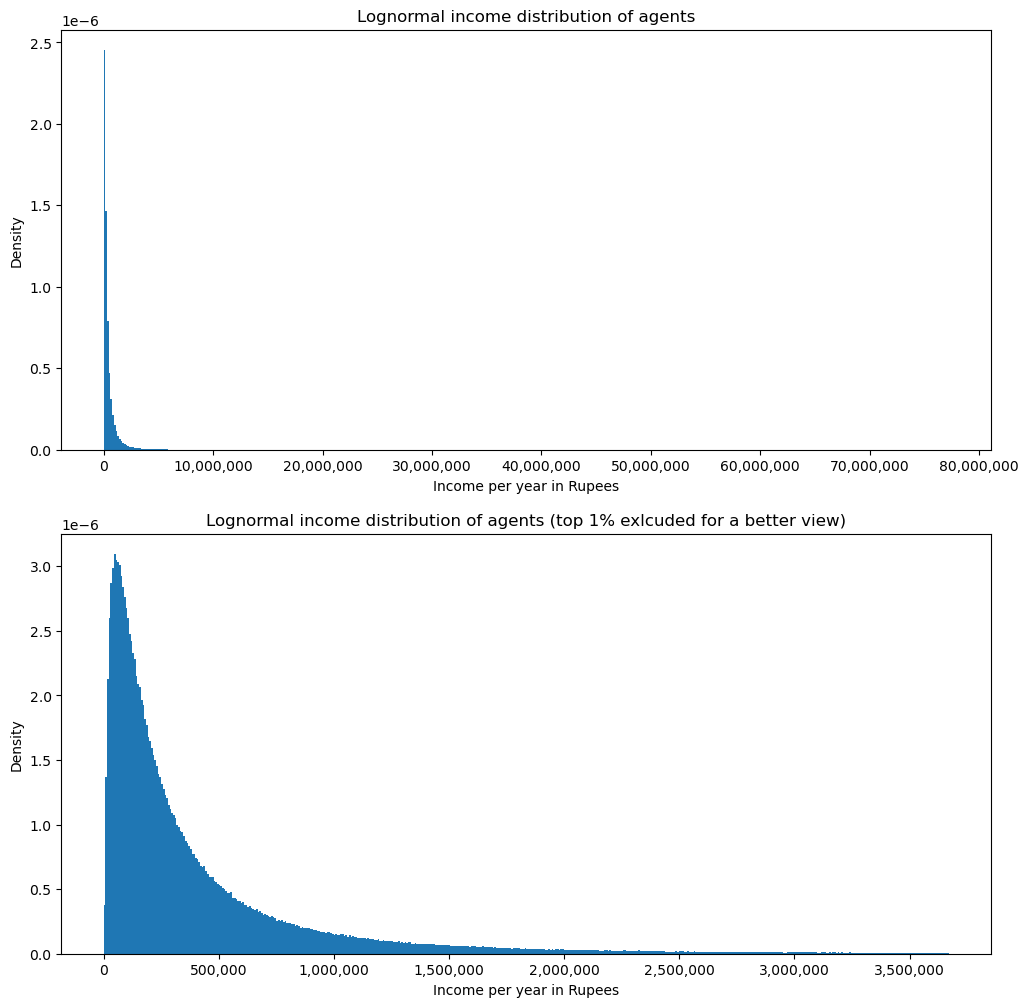

In [10]:
# plot the lognormal agents income distribution
incomes = agents["income"]

# Cut off at, say, the 99.99th percentile for visualization
cutoff = np.percentile(incomes, 99.0)
incomes_percentile = incomes[incomes <= cutoff]

fig, axes = plt.subplots(2,1,figsize = (12,12)) # one plot for actual income distr, one with top 1% cut off
axes[0].hist(incomes, bins = 500, density = True)
axes[0].set_title("Lognormal income distribution of agents")
axes[0].set_xlabel("Income per year in Rupees")
axes[0].set_ylabel("Density")
# format x-axis numbers with commas
axes[0].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# with top 1% cut off
axes[1].hist(incomes_percentile, bins = 500, density = True)
axes[1].set_title("Lognormal income distribution of agents (top 1% exlcuded for a better view)")
axes[1].set_xlabel("Income per year in Rupees")
axes[1].set_ylabel("Density")
axes[1].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()